<a href="https://colab.research.google.com/github/Viny2030/HUMAI/blob/main/ejercicios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/NLP/1_Introduccion/ejercicios/ejercicios.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

## LSA

El **"Análisis Semántico Latente"** es una técnica para cuantificar el contenido y significado de documentos que fue extensamente utilizada desde su origen en la década de 1980.

El procedimiento es el siguiente:
- Computar dado un corpus de textos una matriz de co-ocurrencias.  
- Aplicar una reducción de dimensionalidad sobre esa matriz.
- Esto nos otorga ***embeddings***, o vectores de palabras, y de documentos, que resumen su significado. Con los mismos podemos operar en el "espacio latente".

**Descargar corpus de textos**

In [2]:
#@title Preparamos Dataset de Medios de LatAm
%%capture
!pip install datasets
import pandas as pd
from datasets import load_dataset

data = [] # Initialize data as a list
configs = ['ar', 'bo', 'br', 'cl', 'co', 'cr', 'gt', 'hn', 'mx', 'ni', 'pa', 'pe', 'pr', 'py', 'sv', 'uy', 've'] # 'com', 'es'
for c in configs:
  data_ = load_dataset("LeoCordoba/CC-NEWS-ES", c)
  data.append(data_['train'].to_pandas()) # Append each DataFrame to the list

data = pd.concat(data, ignore_index=True) # Concatenate all DataFrames in the list
data = data.drop('id', axis=1).reset_index(drop=True)
# Hacemos "downsampling" tomando maximo n_min para
# los grupos que tienen > n_min, y todos para los que tienen menos
n_min = 1000
df_grouped = data.groupby("country")
df_grouped.groups.values()
frames_of_groups = [x.sample(n_min) if x.shape[0] > n_min else x for y, x in df_grouped]
data = pd.concat(frames_of_groups)

In [3]:
data

,country,text
113254,ar,Hay momentos en los que los grandes inversores...
172888,ar,El sospechoso había sido apresado en Rosario l...
214136,ar,"Este martes, la mesa chica cegetista se reunir..."
225104,ar,Dijo que “la primera forma de dar estabilidad ...
197611,ar,"""La autonomía de estos combustibles depende de..."
...,...,...
1904173,ve,El 30 de enero el AAIB anunció el inicio de un...
1892205,ve,En Argentina retiraron de los anaqueles el pro...
1897324,ve,La primera cancha recuperada está ubicada en l...
1909695,ve,"CARACAS – Este jueves, 04 de julio, el Alto Co..."


In [4]:
# Ejecutar la celda de arriba para preparar los datos
print(data.shape[0])
data.sample(2)

15561


,country,text
748034,co,‘Chiki Dance’ es una propuesta nueva con el fi...
1812881,uy,Este viernes se llevará a cabo la Primera Conf...


In [5]:
data.country.value_counts()

,count
country,
ar,1000
bo,1000
uy,1000
py,1000
pr,1000
pe,1000
pa,1000
ni,1000
mx,1000


**Buscar los N términos más frecuentes**

(pueden hacerlo con lo que prefieran: Python base, con NLTK, con collections.Counter...)

**Repetir quitando stop words***

In [6]:
!pip install stop_words
import stop_words
# Usamos stop words del español
stop_words = stop_words.get_stop_words('es')

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32894 sha256=befc6374d8725c3b45de4547aaa1095e27e646a4d06f22906a8642dcff6f8d04
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


In [7]:
import itertools
import re
from collections import Counter

n = 20
# Extraemos todas las palabras con regex
words = data.text.str.lower().str.findall("[A-zA-ú]+").tolist()
# Unimos listas de palabras
words = list(itertools.chain(*words))
# Descartamos números
words = [w for w in words if not re.match('(\d+)', w) and w not in stop_words]
word_counts = Counter(words)

In [8]:
word_counts.most_common()[:n]

[('años', 8312),
 ('si', 6309),
 ('país', 6224),
 ('ser', 6146),
 ('dos', 5735),
 ('nacional', 5591),
 ('parte', 5357),
 ('año', 5181),
 ('gobierno', 4869),
 ('personas', 4828),
 ('dijo', 4717),
 ('presidente', 4547),
 ('según', 4177),
 ('así', 4064),
 ('millones', 3751),
 ('además', 3738),
 ('vida', 3497),
 ('tres', 3426),
 ('hace', 3378),
 ('solo', 3315)]

**Aplicar TF-IDF**:

- Usar la clase de sklearn
- Utilizar hasta 2 ngramas
- Utilizar los parámetros de TF-IDF para descartar tokens que aparezcan "poco" (definirlo con esos parámetros)

**Aplicar clustering sobre los documentos, usando la matriz de TF-IDF.**

Pueden usar cualquier algorítmo de clustering (KMeans, HDBscan...)

In [10]:
# Vectorizamos el texto con TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                             min_df=2, stop_words=stop_words)

X = vectorizer.fit_transform(data.text)

print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 15561, n_features: 10000


In [11]:
# Armamos el pipeline porque el TruncatedSVD no devuelve los datos normalizados
# (va a ser importante normalizar para la etapa posterior)
svd = TruncatedSVD(100,random_state = 1)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(X)

In [12]:
# Clusterizamos con KMeans
from sklearn.cluster import KMeans
k = 10
km = KMeans(n_clusters=k, max_iter=100, n_init=10, random_state = 1)
km.fit(X)

KMeans(max_iter=100, n_clusters=10, n_init=10, random_state=1)

In [13]:
# Los centroides están mapeados en el espacio de dimensiones reducidas
# Hacemos la transformación inversa para ver el peso de los features originales (10000 dim)
original_space_centroids = svd.inverse_transform(km.cluster_centers_)

# La función argsort nos da los índices ordenados
order_centroids = original_space_centroids.argsort()[:, ::-1]

# Imprimimos los términos más "pesados" (frecuentes) para cada categoría
# Con los índices ordenados, llamamos a la descripción de las palabras que construyó el Vectorizer()
terms = vectorizer.get_feature_names_out()

print("Ranking de términos por tópico:")

for i in range(k):
    print("Tópico  %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

# Nos quedamos con los 10 índices ordenados más importantes en cada tópico
# Los tópicos parecen tener sentido: Tópico 0(religion), Tópico 1(gráficos) y Tópico 2(espacio)

Ranking de términos por tópico:
Tópico  0: salud hospital pacientes médicos personas médico atención servicios población enfermedades
Tópico  1: policía años dos lugar según personas mujer autoridades hombre víctima
Tópico  2: desarrollo país empresas año parte empresa trabajo educación además sector
Tópico  3: the música película años historia artista artistas mundo año mejor
Tópico  4: ciudad panamá personas san agua años 2019 día 00 nacional
Tópico  5: equipo partido final dos copa fútbol club torneo jugadores primera
Tópico  6: venezuela maduro trump presidente guaidó unidos gobierno país países nicolás
Tópico  7: gobierno presidente electoral país partido dijo ley política elecciones nacional
Tópico  8: si vida ser siempre bien gente día dijo años hacer
Tópico  9: millones dólares 000 us mil año pesos según 2018 país


**Visualizar los clusters, en 2D o en 3D**

Con matplotlib, seaborn o plotly

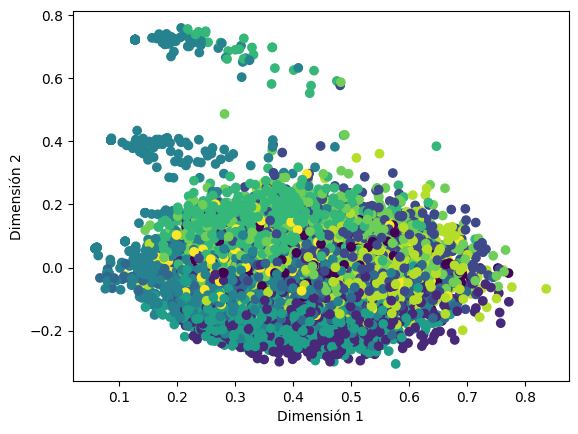

In [14]:
# Visualizamos los clusters en el espacio reducido
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=km.labels_)
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.show()

**Buscar las palabras más frecuentes por cluster**

In [15]:
# Los centroides están mapeados en el espacio de dimensiones reducidas
# Hacemos la transformación inversa para ver el peso de los features originales (10000 dim)
original_space_centroids = svd.inverse_transform(km.cluster_centers_)

# La función argsort nos da los índices ordenados
order_centroids = original_space_centroids.argsort()[:, ::-1]

# Imprimimos los términos más "pesados" (frecuentes) para cada categoría
# Con los índices ordenados, llamamos a la descripción de las palabras que construyó el Vectorizer()
terms = vectorizer.get_feature_names_out()

print("Ranking de términos por tópico:")

for i in range(k):
    print("Tópico  %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

# Nos quedamos con los 10 índices ordenados más importantes en cada tópico
# Los tópicos parecen tener sentido: Tópico 0(religion), Tópico 1(gráficos) y Tópico 2(espacio)

Ranking de términos por tópico:
Tópico  0: salud hospital pacientes médicos personas médico atención servicios población enfermedades
Tópico  1: policía años dos lugar según personas mujer autoridades hombre víctima
Tópico  2: desarrollo país empresas año parte empresa trabajo educación además sector
Tópico  3: the música película años historia artista artistas mundo año mejor
Tópico  4: ciudad panamá personas san agua años 2019 día 00 nacional
Tópico  5: equipo partido final dos copa fútbol club torneo jugadores primera
Tópico  6: venezuela maduro trump presidente guaidó unidos gobierno país países nicolás
Tópico  7: gobierno presidente electoral país partido dijo ley política elecciones nacional
Tópico  8: si vida ser siempre bien gente día dijo años hacer
Tópico  9: millones dólares 000 us mil año pesos según 2018 país


## Extra:

Ver Social Listening en Twitter en [este Colab](https://github.com/institutohumai/talleres/blob/master/Twitter_Social_Listening_ejemplo.ipynb), que tiene un proceso muy completo de NLP, incluyendo visualización de clusters en 3D y word clouds :)
